### Check the dissipation properties of the ANN MITgcm

In [1]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt
from datatree import DataTree
from datatree import open_datatree
import xgcm
import optax
from flax.training import train_state
from flax.training import checkpoints

In [2]:
import sys
sys.path.append('../modules/')
import helper_func as hf
import ml_helper_func as ml_hf

In [3]:
data_bucket = 'gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day/'

ds_50km = xr.open_zarr(f'{data_bucket}ml_data_'+'50'+'km.zarr')
ds_100km = xr.open_zarr(f'{data_bucket}ml_data_'+'100'+'km.zarr')
ds_200km = xr.open_zarr(f'{data_bucket}ml_data_'+'200'+'km.zarr')
ds_400km = xr.open_zarr(f'{data_bucket}ml_data_'+'400'+'km.zarr')

In [4]:
output_channels = ['Sfnx','Sfny']                                      

input_channels = ['U_x', 'U_y', 
                  'V_x', 'V_y', 
                  'Sx', 'Sy', 'Lfilt']

In [5]:
load_model = 'MITgcm'

if load_model == 'MOM6':
    #size_name = 'small'
    #layer_sizes = [24, 24, 2]

    size_name = 'medium'
    layer_sizes = [32, 32, 2]

    #size_name = 'large'
    #layer_sizes = [64, 64, 2]

    model, params = ml_hf.initialize_model(layer_sizes, len(input_channels) )

    learning_rate = .01
    tx = optax.adam(learning_rate=learning_rate)

    state = train_state.TrainState.create(
                apply_fn=model.apply, params=params, tx=tx)

    # Read back from the checkpoint
    CKPT_DIR = '../train_models/train_on_MOM6_data/ckpts_single_all_res_' + size_name
    state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
    ANN_nc = xr.open_dataset('../train_models/train_on_MOM6_data/ann_params_all_res_'+size_name+'.nc')
    
elif load_model=='MITgcm': 
    size_name = 'large'
    layer_sizes = [64, 64, 2]

    model, params = ml_hf.initialize_model(layer_sizes, len(input_channels) )

    learning_rate = .01
    tx = optax.adam(learning_rate=learning_rate)

    state = train_state.TrainState.create(
                apply_fn=model.apply, params=params, tx=tx)

    # Read back from the checkpoint
    CKPT_DIR = '../train_models/ckpts_single_all_res_large'
    state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
    ANN_nc = xr.open_dataset('../train_models/ann_params_all_res_large.nc')

In [6]:
def ANN_pred(ds_L, L):
    ds_test = xr.Dataset()
    
    ds_test['Sx'] = ds_L.slope_x.isel(zi=1)
    ds_test['Sy'] = ds_L.slope_y.isel(zi=1)
    ds_test['Lfilt'] = ds_L.h.isel(zl=0)*0. + L
    
    # For the gradients we have some choices to make 
    
    choice = 1 # 0 thickness weighted, 1 bottom layer, 2 top layer
    # Choose 0, since that is what we are currently using in online sims
    if choice == 0:
        ds_test['U_x'] = (ds_L.dudx * ds_L.h).sum('zl') / ds_L.h.sum('zl') #* 0.
        ds_test['U_y'] = (ds_L.dudy * ds_L.h).sum('zl') / ds_L.h.sum('zl') #* 0.
        ds_test['V_x'] = (ds_L.dvdx * ds_L.h).sum('zl') / ds_L.h.sum('zl') #* 0.
        ds_test['V_y'] = (ds_L.dvdy * ds_L.h).sum('zl') / ds_L.h.sum('zl') #* 0.
    elif choice ==1: 
        ds_test['U_x'] = ds_L.dudx.isel(zl=1)
        ds_test['U_y'] = ds_L.dudy.isel(zl=1)
        ds_test['V_x'] = ds_L.dvdx.isel(zl=1)
        ds_test['V_y'] = ds_L.dvdy.isel(zl=1)
        
    ds_test['Sfnx'] = ds_L.uh_sg.isel(zl=1)
    ds_test['Sfny'] = ds_L.vh_sg.isel(zl=1)
    
    input_norms = ANN_nc.input_norms.rename({'input':'variable'})
    output_norms = ANN_nc.output_norms.rename({'output':'variable'})
    
    ds_test_small = ds_test.isel(Time=slice(0,None)).sel(yh=slice(L, 1600-L))
    
    ds_input = ds_test_small[input_channels].to_array().transpose(...,'variable')/input_norms
    
    ds_output = ds_test_small[output_channels].to_array().transpose(...,'variable')#/output_norms
    
    x0 = np.zeros(7)
    x0[6] = L/input_norms[6]
    y_0 = state.apply_fn(state.params, x0)
    y_0
    
    y_pred = state.apply_fn(state.params, ds_input) 
    
    ds_pred = xr.DataArray(y_pred, dims = ds_output.dims, coords = ds_output.coords)*output_norms
    ds_pred_no_bias = xr.DataArray(y_pred-y_0, dims = ds_output.dims, coords = ds_output.coords)*output_norms
    
    return ds_test, ds_pred_no_bias.to_dataset('variable'), ds_pred.to_dataset('variable')

In [7]:
ds_test_50km, ds_pred_no_bias_50km, ds_pred_50km = ANN_pred(ds_50km, 50.)
ds_test_100km, ds_pred_no_bias_100km, ds_pred_100km = ANN_pred(ds_100km, 100.)
ds_test_200km, ds_pred_no_bias_200km, ds_pred_200km = ANN_pred(ds_200km, 200.)
ds_test_400km, ds_pred_no_bias_400km, ds_pred_400km = ANN_pred(ds_400km, 400.)

In [8]:
def plot_all(idT=0, ds = ds_test_100km, ds_pred = ds_pred_100km):
    plt.figure(figsize=(18,7))

    vmin = -1
    
    robust=True

    plt.subplot(251)
    ds.U_x.isel(Time=idT).plot(robust=robust)
    plt.title('U_x')

    plt.subplot(256)
    ds.U_y.isel(Time=idT).plot(robust=robust)
    plt.title('U_y')

    plt.subplot(252)
    ds.V_x.isel(Time=idT).plot(robust=robust)
    plt.title('V_x')

    plt.subplot(257)
    ds.V_y.isel(Time=idT).plot(robust=robust)
    plt.title('V_y')

    plt.subplot(253)
    ds.Sx.isel(Time=idT).plot(robust=robust)
    plt.title('Slope x')

    plt.subplot(258)
    ds.Sy.isel(Time=idT).plot(robust=robust)
    plt.title('Slope y')

    plt.subplot(254)
    ds.Sfnx.isel(Time=idT).plot(robust=robust)
    plt.title('Sfn x')

    plt.subplot(259)
    ds.Sfny.isel(Time=idT).plot(robust=robust)
    plt.title('Sfn y')

    plt.subplot(255)
    ds_pred.Sfnx.isel(Time=idT).plot(robust=robust)
    plt.title('Sfn x')
    plt.ylim([0, 1600])

    plt.subplot(2,5, 10)
    ds_pred.Sfny.isel(Time=idT).plot(robust=robust)
    plt.title('Sfn y')
    plt.ylim([0, 1600])

    plt.tight_layout()

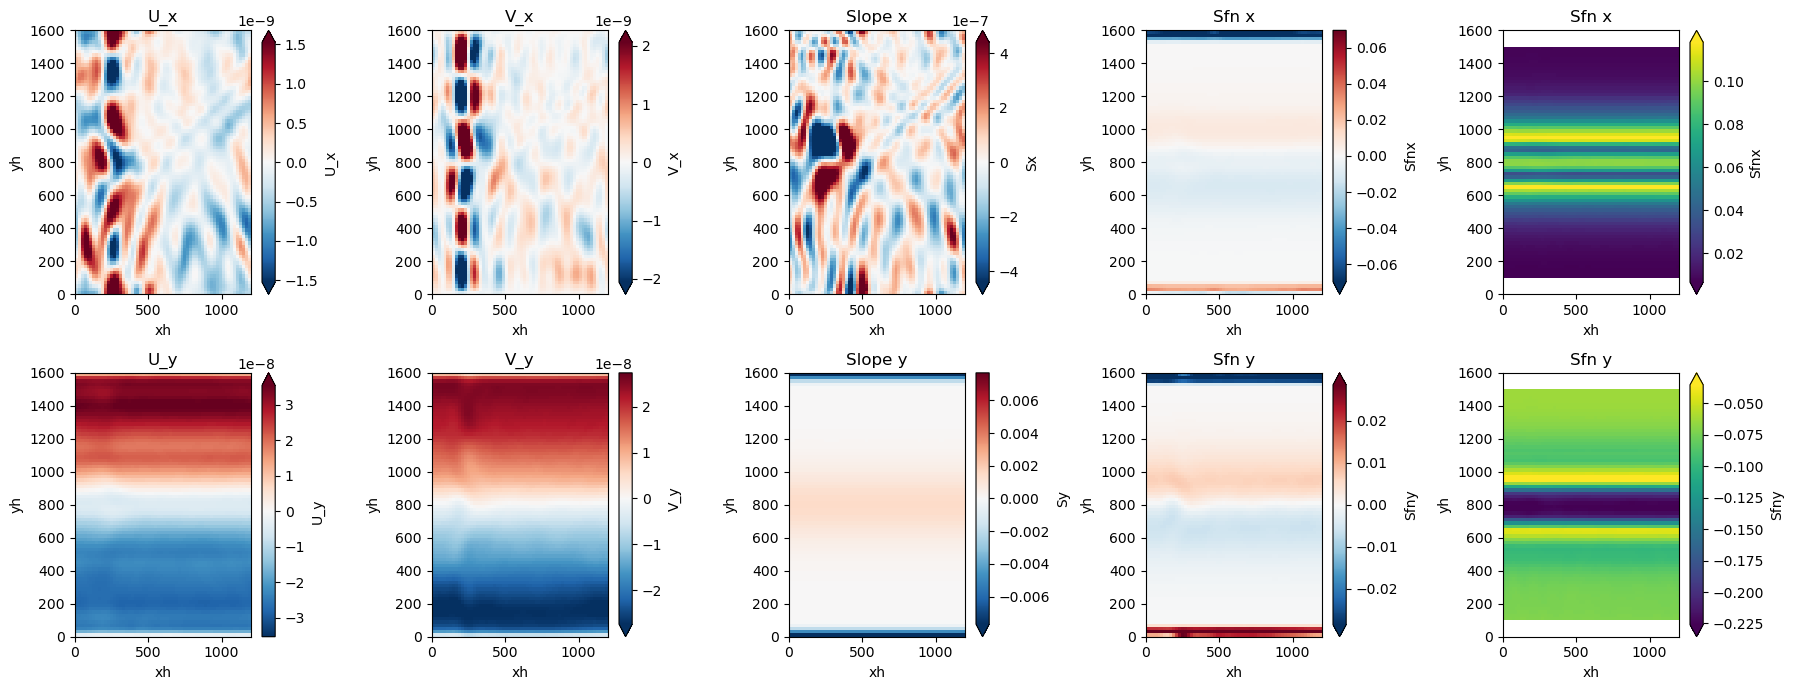

In [9]:
plot_all(0)

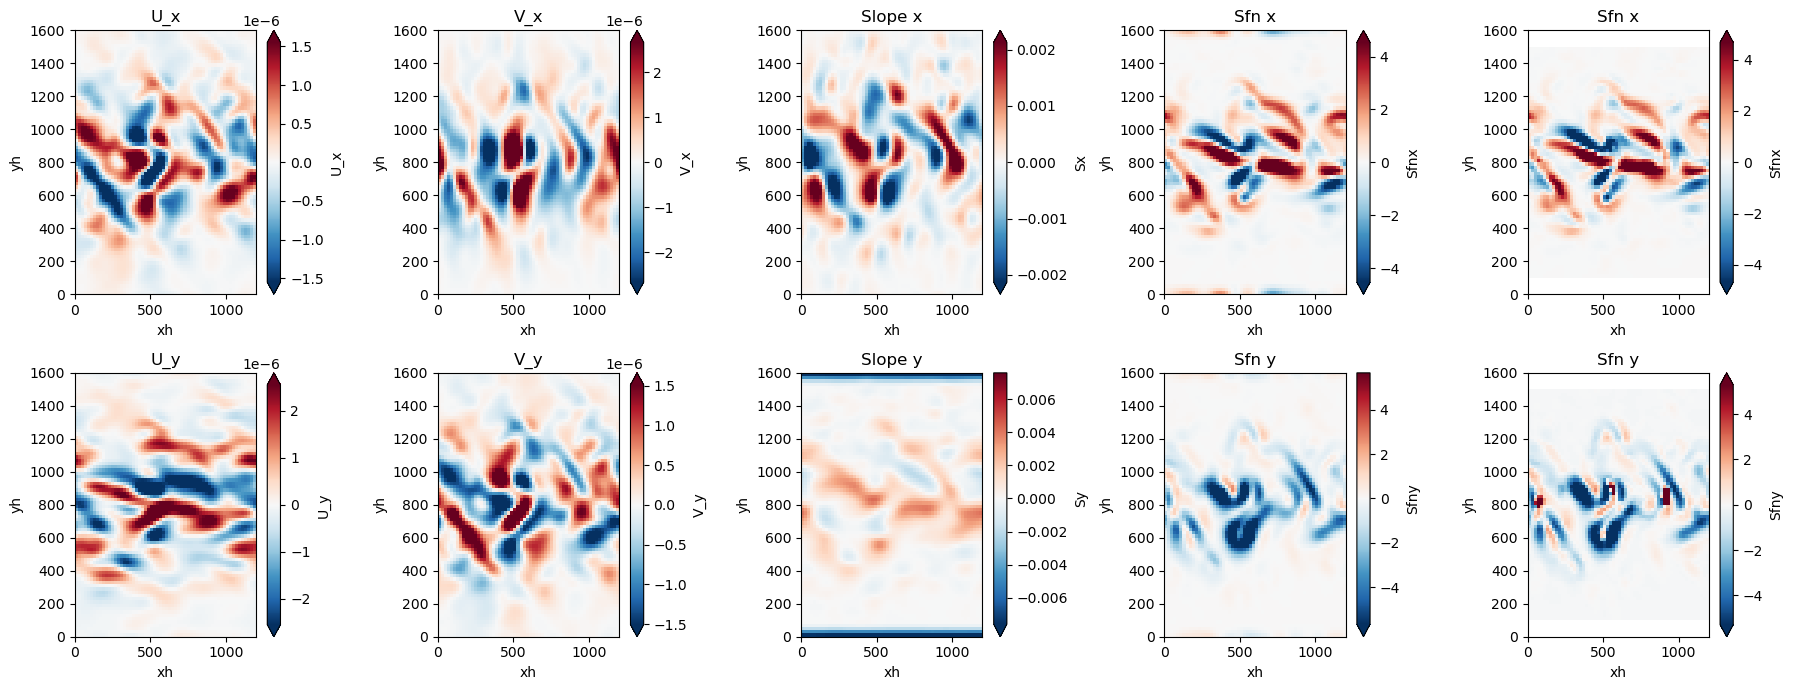

In [10]:
plot_all(-1)

In [11]:
def dissipative_prop(ds= ds_test_100km, ds_pred= ds_pred_100km):

    S_mag = ds.Sx*ds.Sx + ds.Sy*ds.Sy
    diss_true = ds.Sx*ds.Sfnx + ds.Sy*ds.Sfny
    diss_pred = ds.Sx*ds_pred.Sfnx + ds.Sy*ds_pred.Sfny
    
    return diss_true/S_mag, diss_pred/S_mag

In [12]:
diss_true_400km, diss_pred_400km = dissipative_prop(ds= ds_test_400km, ds_pred= ds_pred_400km)
diss_true_200km, diss_pred_200km = dissipative_prop(ds= ds_test_200km, ds_pred= ds_pred_200km)
diss_true_100km, diss_pred_100km = dissipative_prop(ds= ds_test_100km, ds_pred= ds_pred_100km)
diss_true_50km, diss_pred_50km = dissipative_prop(ds= ds_test_50km, ds_pred = ds_pred_50km)

In [13]:
def plot_diss(idT=-1, diss_true=diss_true_100km, diss_pred=diss_pred_100km, L=100., 
                    vmin=-1000, vmax=1000): 
    plt.figure(figsize=(8, 3))
    idT = -1

    
    plt.subplot(121)
    diss_true.isel(Time=idT).sel(yh=slice(L,1600-L)).plot(robust=True,
                                                          cmap='RdBu_r',vmin=vmin, vmax=vmax)
    plt.title('True')
    plt.ylim([0, 1600])
    
    plt.subplot(122)
    diss_pred.isel(Time=idT).sel(yh=slice(L,1600-L)).plot(robust=True, 
                                                          cmap='RdBu_r',vmin=vmin, vmax=vmax)
    plt.title('Pred')
    plt.ylim([0, 1600])

    plt.tight_layout()
    plt.suptitle(L)

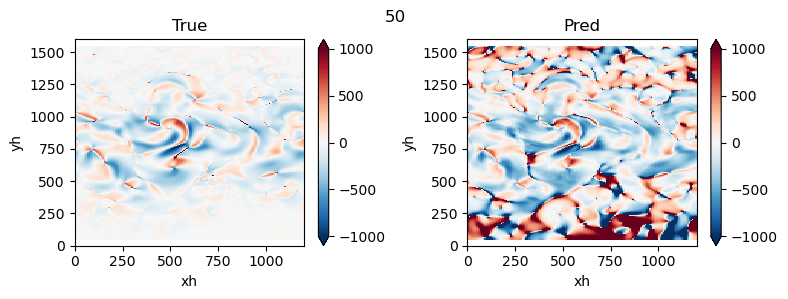

In [14]:
plot_diss(-2, diss_true_50km, diss_pred_50km, 50)

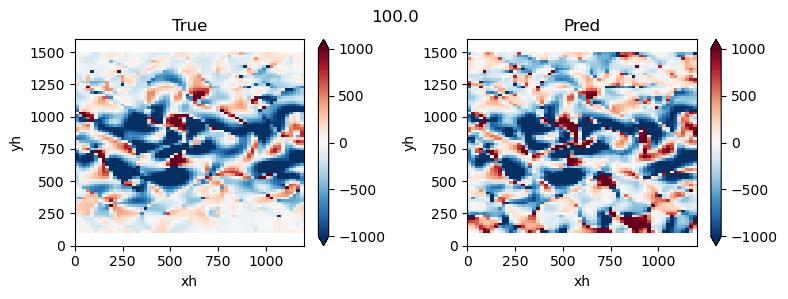

In [15]:
plot_diss(-2)

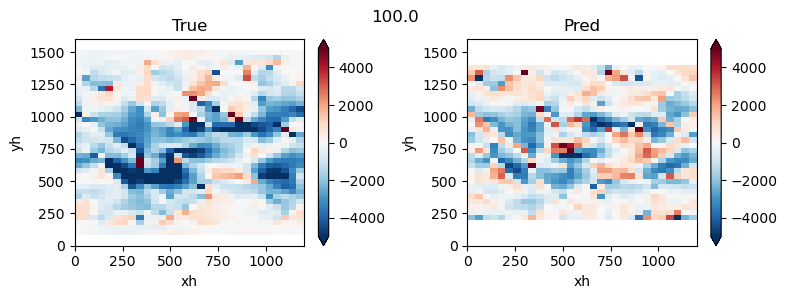

In [16]:
plot_diss(-2, diss_true_200km, diss_pred_200km, vmin=-5e3, vmax=5e3)

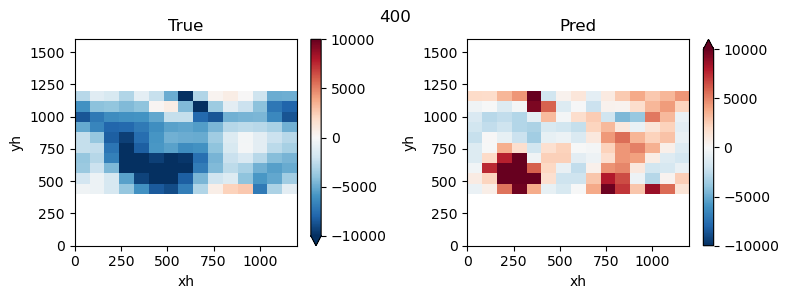

In [17]:
plot_diss(-2, diss_true_400km, diss_pred_400km, 400, vmin=-10e3, vmax=10e3)

In [20]:
def plot_panel(diss_true, diss_pred, L): 
    
    bins = np.linspace(-50e3, 50e3, 51)
    true_sel = diss_true.isel(Time=slice(0, None)).sel(yh=slice(400,1200))
    pred_sel = diss_pred.isel(Time=slice(0, None)).sel(yh=slice(400,1200))

    mean_true = true_sel.mean()
    mean_pred = pred_sel.mean()

    true_sel.plot.hist(bins=bins)
    pred_sel.plot.hist(bins=bins, alpha=0.5)
    plt.yscale('log')
    plt.grid()
    plt.title(str(L)+', (MEAN : True:' + str(mean_true.values) + ', Pred:' + str(mean_pred.values))

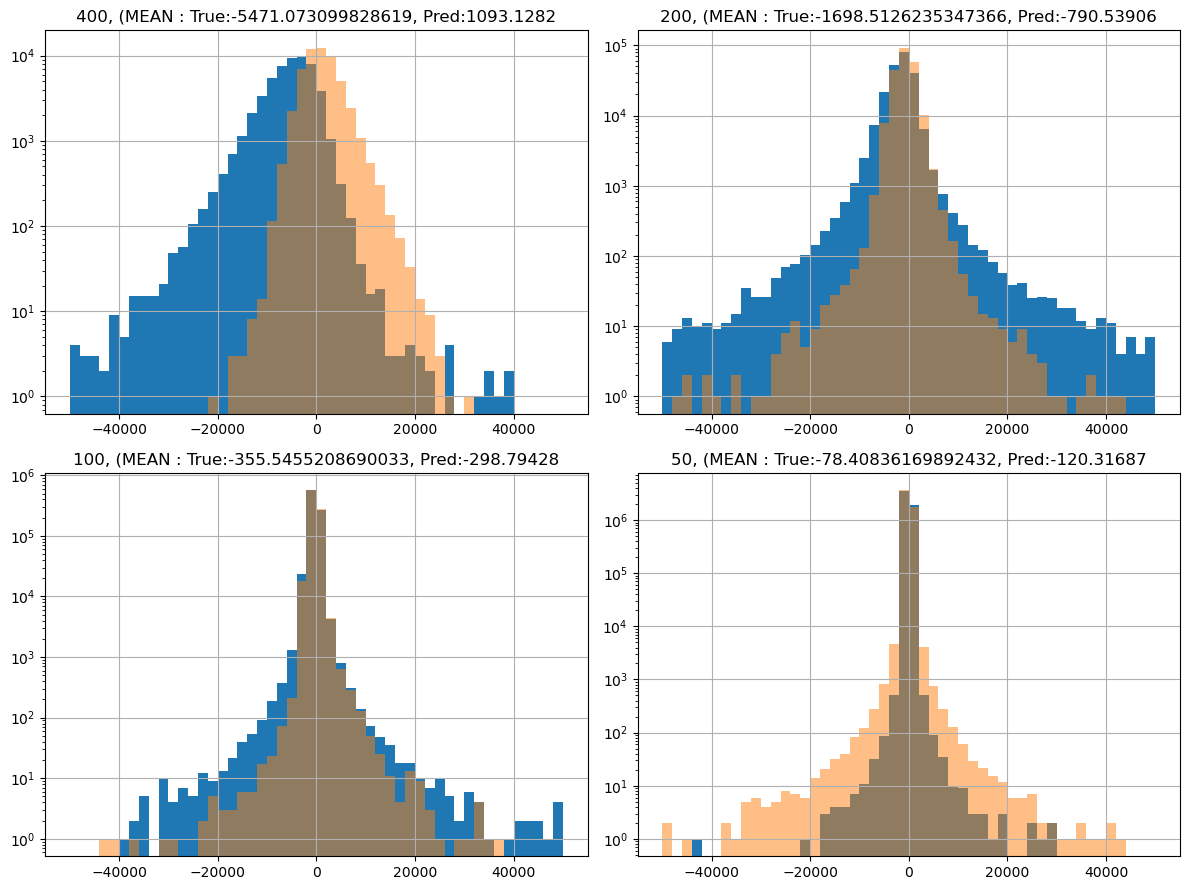

In [21]:
plt.figure(figsize=(12,9))

plt.subplot(221)
plot_panel(diss_true_400km, diss_pred_400km, 400)

plt.subplot(222)
plot_panel(diss_true_200km, diss_pred_200km, 200)

plt.subplot(223)
plot_panel(diss_true_100km, diss_pred_100km, 100)

plt.subplot(224)
plot_panel(diss_true_50km, diss_pred_50km, 50)


plt.tight_layout()